# Kaggle Titanic Project V4

In this notebook, I attempt to complete Kaggle's infamous Titanic competition. This notebook will encompass all steps of my project, from data cleaning, exploratory data analysis (EDA) and modelling.

The aim of this project is to use the Titanic data provided to predict who will live and who will die.

In [420]:
# For data handling, cleaning and manipulation.
import numpy as np
import pandas as pd

# For data visualisation
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# For modelling
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from scipy.stats import chi2_contingency
from matplotlib.gridspec import GridSpec
from pandas.api.types import is_numeric_dtype
import statsmodels.api as sm
import shap
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score

# Utitlity tools
from IPython.display import display
import time

## Part 0: Breakdown of Columns

For my personal reference, the dataset's columns are as follows:

1. **Survival**: This column reflects whether a passenger survived ('1') or did not ('0'). *This is the 'y' variable we're predicting*.
2. **Pclass**: This refers to a passenger's ticket class. According to Kaggle, it can stand in as a proxy for a passenger's Socio-Economic Status (SES). (1, 2 or 3)
3. **Sex**: This refers to a passenger's sex. (male or female)
4. **Age**: This refers to a passenger's age. According to Kaggle, "age is fractional if less than 1. If the age is estimated, is it in the form of xx.5".
5. **SibSp**: This refers to the number of siblings or spouses the passenger had on board the Titanic. Brothers, sisters, step-siblings, husbands and wives are considered. Fiancees or mistressess are not.
6. **Parch**: This refers to the number of parents or children the passenger boarded with. Some children travelled with a nanny, and thus have a Parch = 0.
7. **Ticket**: This refers to the passenger's ticket number. It is a unique value for each passenger.
8. **Fare**: This refers to the amount of money the passenger spent to board.
9. **Cabin**: This refers to the cabin the passenger stayed in.
10. **Embarked**: This refers to where the passenger boarded the ship. (C = Cherbourg, S = Southampton, Q = Queenstown)

## Part 1: Loading Data & First Impressions

In [424]:
train_set = pd.read_csv('/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/Personal Projects/Kaggle Titanic Competition/Datasets/train.csv')
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [425]:
train_set.shape

(891, 12)

In [426]:
round(train_set.isnull().sum()/len(train_set)*100,2)

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

Immediately, we see that we will need to address some null values in the dataset, especially under 'Age' and 'Cabin', where more than 10% of rows have null values.  

In [428]:
round(train_set['Survived'].value_counts()/len(train_set)*100,2)

Survived
0    61.62
1    38.38
Name: count, dtype: float64

Generally, the data is also skewed towards non-survivors, with them occupying roughly 60% of the data.

## Part 2: Cleaning the Data

### Looking into Null Values under 'Embarked'

In [432]:
train_set[train_set['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Based on [publicly available information](https://www.encyclopedia-titanica.org/explorer/), it is possible to see where those with null values under 'Embarked' boarded the ship.

I found that Miss Amelie Icard [boarded at Southampton](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html), and [so did Mrs. George Nelson Stone](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html). I will impute 'S' under 'Embarked' for both of them.

In [434]:
# For Amelie Stone
train_set.iloc[61,-1] = 'S'
# For George Nelson Stone
train_set.iloc[829,-1] = 'S'

In [435]:
# 'Embarked' no longer has any null values
train_set['Embarked'].isnull().sum()

0

### Looking into Null Values under 'Age'

Ultimately, age is an important measure which might benefit the accuracy of the model. For this reason, I don't want to simply drop the column. However, it is also difficult to impute the null values.

I'll make a compromise and impute the median of age, but to make the imputation less general, I will impute the median of the age according to 'Pclass' and 'Sex'.

I'm using the median because the median does not account for outliers in the data. Relative to the mean, the median is less likely to skew the age data after imputation.

In [438]:
train_set['Age'] = train_set.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

In [439]:
# 'Age' no longer has any null values
train_set['Age'].isnull().sum()

0

### Looking into Null Values under 'Cabin'

In [441]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


At this point, I am contemplating whether to drop 'Cabin' altogether. As seen earlier, over 70% of values under 'Cabin' are null, which is almost completely unusable for predictive modelling. 

Now, I want to see if the ratio of survivors to non-survivors among those with non-null 'Cabin' is similar to that among those with null 'Cabin'. If the ratio is similar, dropping the column will not result in the loss of important information in the dataset.

In [443]:
round(train_set[train_set['Cabin'].notnull()]['Survived'].value_counts()/204*100,2)

Survived
1    66.67
0    33.33
Name: count, dtype: float64

2/3 of those with a non-null 'Cabin' survived!

In [445]:
round(train_set[train_set['Cabin'].isnull()]['Survived'].value_counts()/687*100,2)

Survived
0    70.01
1    29.99
Name: count, dtype: float64

Hmm. The ratio is almost reversed for those with null 'Cabin', where 2/3 of those with null 'Cabin' DID NOT survive. What percentage of the dataset consists of non-survivors with a null value under 'Cabin'?

In [447]:
round(train_set[(train_set['Cabin'].isnull())&(train_set['Survived']==0)].shape[0]/len(train_set)*100,2)

53.98

Yikes. It turns out that more than half of the dataset overall consists of non-survivors whose 'Cabin' is also null. 

Since non-survivors occupy roughly 60% of the dataset overall, we can conclude that non-survivors are likely to also have a null value under 'Cabin' *and vice versa*, meaning that there is actually somewhat a correlation between having a null value under 'Cabin' and not surviving.

This is information that might not be advisable to omit from the dataset, but we also need to deal with the null values under 'Cabin'. As a compromise, I have decided to create a new binary column 'HasCabin' so the correlation betweeen a null 'Cabin' and not surviving remains as a signal in the data.

#### Creating 'HasCabin'

In [450]:
def hascabin(x):
    if pd.notnull(x):
        return 1
    else:
        return 0

train_set['HasCabin'] = train_set['Cabin'].apply(hascabin)
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [451]:
# Finally, let's drop 'Cabin', as its high concentration of null values won't be helpful for us.
train_set = train_set.drop('Cabin',axis=1)
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


### Final Check on Null Values

In [453]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  HasCabin     891 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


All null values have been addressed.

### Checking for Duplicate Rows

In [456]:
train_set.duplicated().sum()

0

There should be unique values under 'PassengerId' and 'Name'. Let me check if those columns have any duplicates. (While 'Ticket' sounds like there should only be unique values, I found out that passengers travelling together can share ticket numbers)

In [458]:
train_set.duplicated(subset=['PassengerId','Name']).sum()

0

### Check on Data Types

In [460]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  HasCabin     891 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


The datatypes do not look problematic at this point. Let me just round the values under 'Fare' to 2 decimal places so the values are more readable.

#### Rounding 'Fare' to 2 d.p.

In [463]:
train_set['Fare'] = round(train_set['Fare'],2)
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,S,0


### Checking for Nonsensical Values

The dataset should not contain the following data:

1. Negative values under the numerical columns
2. 'Sex' not being 'male' or 'female'
3. 'Pclass' not being 1, 2 or 3
4. 'Embarked' not 'S','Q' or 'C'
5. 'Survived' not 1 or 0

#### Negative Values

In [467]:
num_negative_check = (train_set['PassengerId'] < 0)|(train_set['Survived'] < 0)|(train_set['Pclass'] < 0)|(train_set['Age'] < 0)|(train_set['SibSp'] < 0)|(train_set['Parch'] < 0)|(train_set['Fare'] < 0)
train_set[num_negative_check]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin


#### 'Sex' not 'male' or 'female'

In [469]:
train_set[~train_set['Sex'].isin(['male','female'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin


#### 'Pclass' not 1, 2, or 3

In [471]:
train_set[~train_set['Pclass'].isin([1,2,3])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin


#### 'Embarked' not 'S','Q' or 'C'

In [473]:
train_set[~train_set['Embarked'].isin(['S','Q','C'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin


#### 'Survived' not 1 or 0

In [475]:
train_set[~train_set['Survived'].isin([1,0])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin


### Combining 'SibSp' and 'Parch' to form 'PartySize'

Before we go to our EDA section, I want to conduct one last preliminary round of feature engineering by combining 'SibSp' and 'Parch' to form a 'PartySize' column, which reflects the total number of people the passenger travelled with. I will also add 1 to the total to include the passenger themselves.

In [478]:
train_set['PartySize'] = train_set['SibSp']+train_set['Parch']+1
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin,PartySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,S,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C,1,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,S,1,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,S,0,1


In [479]:
# At this point, it is unnecessary to keep 'SibSp' and 'Parch'. Let's drop them.
train_set = train_set.drop(['SibSp','Parch'],axis=1)
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,HasCabin,PartySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.25,S,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.28,C,1,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.92,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.10,S,1,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.05,S,0,1


## Part 3: Exploratory Data Analysis

I have a few objectives in this section:

1. Understand the general profile of surviviors vs. non-survivors

2. Find out about the distribution under continuous features (namely 'Age' and 'Fare'), so I know whether or not to bin the values for better comprehensibility by the model.

### Survivor Analysis

In [483]:
# Let's first create a dataset that filters only the Survivors
survivors = train_set[train_set['Survived']==1]
survivors.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,HasCabin,PartySize
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.28,C,1,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.92,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.10,S,1,2
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,347742,11.13,S,0,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,237736,30.07,C,0,2


In [484]:
# What's the sex composition among survivors?
survivor_sex = survivors['Sex'].value_counts().reset_index()
px.bar(survivor_sex,x='Sex',y='count',text_auto=True,color='Sex',color_discrete_map={'male':'blue','female':'pink'},title='There are twice as many female than male survivors overall.')

In [485]:
# What's the age composition among females?
survivor_females = survivors[survivors['Sex']=='female']
survivor_females_age_count = survivor_females['Age'].value_counts().reset_index()
px.histogram(survivor_females_age_count,x='Age',y='count',text_auto=True,color_discrete_sequence=['lightpink'],title='Female survivors are normally distributed in age, with most being between 20 and 40.')

In [486]:
# What's the age composition among males?
survivor_males = survivors[survivors['Sex']=='male']
survivor_males_age_count = survivor_males['Age'].value_counts().reset_index()
px.histogram(survivor_males_age_count,x='Age',y='count',text_auto=True,color_discrete_sequence=['lightblue'],title='Male survivors are also normally distributed, with most between 25 and 44.')

In [487]:
# What Pclass were survivors from?
survivor_pclass = survivors['Pclass'].value_counts().reset_index()
px.bar(survivor_pclass,x='Pclass',y='count',color='count',text_auto=True,title='Pclass 1 had the most survivors, followed by Pclass 3 then Pclass 2.')

In [488]:
# How much did survivors pay to board?
survivor_fare = survivors['Fare'].value_counts().reset_index()
px.histogram(survivor_fare,x='Fare',y='count',text_auto=True,title='Most survivors paid < $30 to board.')

In [489]:
# Where did Survivors Embark?
survivor_embarked = survivors['Embarked'].value_counts().reset_index()
px.bar(survivor_embarked,x='Embarked',y='count',color='count',text_auto=True,title='Most Survivors Embarked from Southampton.')

In [490]:
survivor_cabin = survivors['HasCabin'].value_counts().reset_index()
px.bar(survivor_cabin,x='HasCabin',y='count',text_auto=True,color='HasCabin',title="Most Survivors' 'Cabin' is Null.")

### Non-Survivor Analysis

In [492]:
# Let's first create a dataset that filters only non-survivors
non_survivors = train_set[train_set['Survived']==0]
non_survivors.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,HasCabin,PartySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.25,S,0,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.05,S,0,1
5,6,0,3,"Moran, Mr. James",male,25.0,330877,8.46,Q,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,17463,51.86,S,1,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,349909,21.08,S,0,5


In [493]:
# What's the sex composition among non-survivors?
nons_sex = non_survivors['Sex'].value_counts().reset_index()
px.bar(nons_sex,x='Sex',y='count',text_auto=True,color='Sex',color_discrete_map={'male':'blue','female':'pink'},title='Non-Survivors are Overwhelmingly Male.')

In [494]:
# What's the age composition among females?
nons_females = non_survivors[non_survivors['Sex']=='female']
nons_females_age_count = nons_females['Age'].value_counts().reset_index()
px.histogram(nons_females_age_count,x='Age',y='count',text_auto=True,color_discrete_sequence=['lightpink'],title='The Largest Demographic of Female Non-Survivors are Between 20 and 30.')

In [495]:
# What's the age composition among males?
nons_males = non_survivors[non_survivors['Sex']=='male']
nons_males_age_count = nons_males['Age'].value_counts().reset_index()
px.histogram(nons_males_age_count,x='Age',y='count',text_auto=True,color_discrete_sequence=['lightblue'],title='Most Male Non-Survivors were Between 20 and 40.')

In [496]:
# What Pclass were non-survivors from?
nons_pclass = non_survivors['Pclass'].value_counts().reset_index()
px.bar(nons_pclass,x='Pclass',y='count',color='count',text_auto=True,title='Non-Survivors were Overwhelmingly from Pclass 3.')

In [497]:
# How much did non-survivors pay to board?
nons_fare = non_survivors['Fare'].value_counts().reset_index()
px.histogram(nons_fare,x='Fare',y='count',text_auto=True,title='The Overwhelming Majority of Non-Survivors Paid < $30 to Board.')

In [498]:
# Where did Non-Survivors Embark?
nons_embarked = non_survivors['Embarked'].value_counts().reset_index()
px.bar(nons_embarked,x='Embarked',y='count',color='count',text_auto=True,title='Most Passengers Embarked at Southampton.')

In [499]:
# How many non-survivors have a non-null 'Cabin'?
nons_cabin = non_survivors['HasCabin'].value_counts().reset_index()
px.bar(nons_cabin,x='HasCabin',y='count',text_auto=True,color='HasCabin',title="The Overwhelming Majority of Non-Survivors' 'Cabin' was Null.")

### General Observations

In [501]:
# There are less children survivors and survivors from the highest Pclass than I expected.
# What percentage of children survived overall? I will define 'children' as < 18 years of age
children = train_set[train_set['Age'] < 18]
children_survive_count = children['Survived'].value_counts().reset_index()
children_survive_count['count'] = round(children_survive_count['count']/len(children)*100,2)
px.bar(children_survive_count, x='Survived',y='count',text_auto=True,color='Survived',title='More children onboard the Titanic survived, but not by a large margin.')

With 'women and children first' serving as the general ethos of emergency situations like the Titanic's sinking, I would have expected children to skew towards survivors, but I do not see that. Children seemed to have a roughly 50/50 chance of survival.

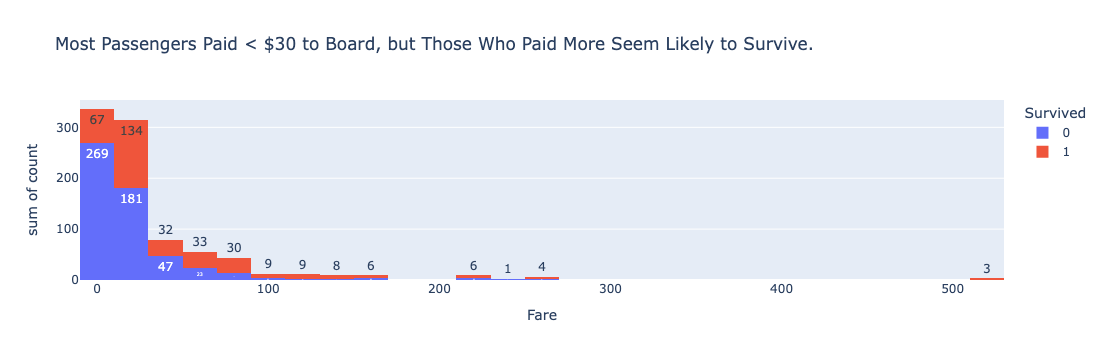

In [503]:
fare_check = train_set.groupby('Survived')['Fare'].value_counts().reset_index()
px.histogram(fare_check,x='Fare',y='count',color='Survived',text_auto=True,title='Most Passengers Paid < $30 to Board, but Those Who Paid More Seem Likely to Survive.')

In [504]:
famsize_check = train_set.groupby('Survived')['PartySize'].value_counts().reset_index()
px.histogram(famsize_check,x='PartySize',y='count',color='Survived',text_auto=True,title='Passengers who Travelled Alone Were Least Likely To Survive.')

### Conclusions on Initial EDA

**Survivors**
1. There are ~twice as many female survivors than male survivors.
2. Pclass 1 had the most survivors, but Pclass 3 was a close second.
3. Those who paid more were more likely to survive.

**Non-Survivors**
1. There are almost 6 times more male non-survivors than female non-survivors.
2. An overwhelming number of non-survivors were from Pclass 3.

**Similar Patterns Between Survivors and Non-Survivors**
1. Most female and male survivors tend to be between 20 and mid-40s.
3. Most passengers are within the 15-35 age group.
4. Most passengers boarded from Southampton, but the ratio of those who boarded from Southampton compared to other ports is higher among non-survivors than survivors.
5. Most passengers travelled alone, but those who travelled alone were least likely to survive.
6. Most passengers across both groups had a null 'Cabin', but they were more likely to be non-survivors.

**Moving Forward**
1. As of now, I am not dropping any columns except the following, which have arbitrary values: 'PassengerId', 'Ticket'.
2. I am unsure whether to implement binning to my continuous variables, 'Age' and 'Fare'. However, I will first try modelling without binning in order to maintain their continuous nature. This is especially since the regression technique I have in mind (random forests) can handle continuous variables well. I want to feed it as much detail as possible.
3. I will, however, try binning 'PartySize' to the following categories: 'Alone', 'Couple', 'Small/Med Family' (For 'PartySize' of 3-5), 'Large Family' (For 'PartySize' of 6 and above). The primary motivation for this is for easier interpretation. Because this feature is not continuous but ordinal, I don't think the model needs the detail that the continuous variables can provide.
4. I also want to try extracting the title from each person's name as I read that those who had the title 'Master' (essentially referring to male children) were more likely to survive.

## Part 4: Further Feature Engineering

There are 3 things I want to do in this section:

1. Drop 'PassengerId' and 'Ticket' as these will only introduce noise to the model
2. Bin 'PartySize' to the categories: 'Alone', 'Couple', 'Small/Med Family' (For 'PartySize' of 3-5), 'Large Family' (For 'PartySize' of 6 and above).
3. Extracting the title from each person's name.

#### Dropping 'PassengerId' and 'Ticket'

In [510]:
train_set = train_set.drop(['PassengerId','Ticket'],axis=1)

In [511]:
train_set.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,HasCabin,PartySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.25,S,0,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.28,C,1,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.92,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.10,S,1,2
4,0,3,"Allen, Mr. William Henry",male,35.0,8.05,S,0,1


#### Binning 'PartySize'

In [513]:
def partybin(x):
    if x == 1:
        return 'Alone'
    elif x == 2:
        return 'Couple'
    elif x > 2 and x < 6:
        return 'SmallMedFamily'
    elif x > 5:
        return 'LargeFamily'

train_set['PartyBinned'] = train_set['PartySize'].apply(partybin)

#### Extracting Title from 'Name'

In [515]:
train_set.head(10)

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,HasCabin,PartySize,PartyBinned
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.25,S,0,2,Couple
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.28,C,1,2,Couple
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.92,S,0,1,Alone
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.10,S,1,2,Couple
4,0,3,"Allen, Mr. William Henry",male,35.0,8.05,S,0,1,Alone
5,0,3,"Moran, Mr. James",male,25.0,8.46,Q,0,1,Alone
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,51.86,S,1,1,Alone
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,21.08,S,0,5,SmallMedFamily
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,11.13,S,0,3,SmallMedFamily
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,30.07,C,0,2,Couple


I notice that a person's title is usually the second word in their respective 'Name' strings. I will now split their strings by space and extract the second word.

In [517]:
train_set['Title'] = train_set['Name'].str.split(' ').str[1]

In [518]:
train_set['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Planke,', 'Don.', 'Rev.',
       'Billiard,', 'der', 'Walle,', 'Dr.', 'Pelsmaeker,', 'Mulder,', 'y',
       'Steen,', 'Carlo,', 'Mme.', 'Impe,', 'Ms.', 'Major.', 'Gordon,',
       'Messemaeker,', 'Mlle.', 'Col.', 'Capt.', 'Velde,', 'the',
       'Shawah,', 'Jonkheer.', 'Melkebeke,', 'Cruyssen,'], dtype=object)

Clearly, there are many names where the title has been incorrectly extracted. Let's isolate these names first.

In [520]:
unusual_title = train_set[~((train_set['Title']=='Mr.')|(train_set['Title']=='Mrs.')|(train_set['Title']=='Miss.'))]

In [521]:
unusual_title['Title'].unique()

array(['Master.', 'Planke,', 'Don.', 'Rev.', 'Billiard,', 'der', 'Walle,',
       'Dr.', 'Pelsmaeker,', 'Mulder,', 'y', 'Steen,', 'Carlo,', 'Mme.',
       'Impe,', 'Ms.', 'Major.', 'Gordon,', 'Messemaeker,', 'Mlle.',
       'Col.', 'Capt.', 'Velde,', 'the', 'Shawah,', 'Jonkheer.',
       'Melkebeke,', 'Cruyssen,'], dtype=object)

##### Dealing with Wrong 'Mr.'

In [523]:
obvious_titles = ['Master.','Don.','Rev.','Dr.','Mme.','Ms.','Major.','Mlle.','Col.','Capt.','Jonkheer.']
wrong_title = unusual_title[~unusual_title['Title'].isin(obvious_titles)]
wrong_title

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,HasCabin,PartySize,PartyBinned,Title
18,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,18.00,S,0,2,Couple,"Planke,"
38,0,3,"Vander Planke, Miss. Augusta Maria",female,18.0,18.00,S,0,3,SmallMedFamily,"Planke,"
153,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,14.50,S,0,3,SmallMedFamily,"Billiard,"
170,0,1,"Van der hoef, Mr. Wyckoff",male,61.0,33.50,S,1,1,Alone,der
200,0,3,"Vande Walle, Mr. Nestor Cyriel",male,28.0,9.50,S,0,1,Alone,"Walle,"
282,0,3,"de Pelsmaeker, Mr. Alfons",male,16.0,9.50,S,0,1,Alone,"Pelsmaeker,"
286,1,3,"de Mulder, Mr. Theodore",male,30.0,9.50,S,0,1,Alone,"Mulder,"
307,1,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",female,17.0,108.90,C,1,2,Couple,y
333,0,3,"Vander Planke, Mr. Leo Edmondus",male,16.0,18.00,S,0,3,SmallMedFamily,"Planke,"
355,0,3,"Vanden Steen, Mr. Leo Peter",male,28.0,9.50,S,0,1,Alone,"Steen,"


In [524]:
mr_index = [153,170,200,282,286,333,355,361,505,547,595,752,798,868,873]
train_set.loc[mr_index,'Title'] = 'Mr.'

##### Dealing with Wrong 'Mrs.'

In [526]:
train_set['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Planke,', 'Don.', 'Rev.',
       'Dr.', 'y', 'Mme.', 'Impe,', 'Ms.', 'Major.', 'Gordon,',
       'Messemaeker,', 'Mlle.', 'Col.', 'Capt.', 'the', 'Jonkheer.'],
      dtype=object)

In [527]:
unusual_title = train_set[~((train_set['Title']=='Mr.')|(train_set['Title']=='Mrs.')|(train_set['Title']=='Miss.'))]
obvious_titles = ['Master.','Don.','Rev.','Dr.','Mme.','Ms.','Major.','Mlle.','Col.','Capt.','Jonkheer.']
wrong_title = unusual_title[~unusual_title['Title'].isin(obvious_titles)]
wrong_title

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,HasCabin,PartySize,PartyBinned,Title
18,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,18.00,S,0,2,Couple,"Planke,"
38,0,3,"Vander Planke, Miss. Augusta Maria",female,18.0,18.00,S,0,3,SmallMedFamily,"Planke,"
307,1,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",female,17.0,108.90,C,1,2,Couple,y
419,0,3,"Van Impe, Miss. Catharina",female,10.0,24.15,S,0,3,SmallMedFamily,"Impe,"
556,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,39.60,C,1,2,Couple,"Gordon,"
559,1,3,"de Messemaeker, Mrs. Guillaume Joseph (Emma)",female,36.0,17.40,S,0,2,Couple,"Messemaeker,"
599,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,56.93,C,1,2,Couple,"Gordon,"
759,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,86.50,S,1,1,Alone,the
799,0,3,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",female,30.0,24.15,S,0,3,SmallMedFamily,"Impe,"
866,1,2,"Duran y More, Miss. Asuncion",female,27.0,13.86,C,0,2,Couple,y


In [528]:
mrs_index = [18,307,559,799]
train_set.loc[mrs_index,'Title'] = 'Mrs.'

##### Dealing with Wrong 'Miss.'

In [530]:
train_set['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Planke,', 'Rev.',
       'Dr.', 'Mme.', 'Impe,', 'Ms.', 'Major.', 'Gordon,', 'Mlle.',
       'Col.', 'Capt.', 'the', 'Jonkheer.', 'y'], dtype=object)

In [531]:
unusual_title = train_set[~((train_set['Title']=='Mr.')|(train_set['Title']=='Mrs.')|(train_set['Title']=='Miss.'))]
obvious_titles = ['Master.','Don.','Rev.','Dr.','Mme.','Ms.','Major.','Mlle.','Col.','Capt.','Jonkheer.']
wrong_title = unusual_title[~unusual_title['Title'].isin(obvious_titles)]
wrong_title

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,HasCabin,PartySize,PartyBinned,Title
38,0,3,"Vander Planke, Miss. Augusta Maria",female,18.0,18.00,S,0,3,SmallMedFamily,"Planke,"
419,0,3,"Van Impe, Miss. Catharina",female,10.0,24.15,S,0,3,SmallMedFamily,"Impe,"
556,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,39.60,C,1,2,Couple,"Gordon,"
599,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,56.93,C,1,2,Couple,"Gordon,"
759,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,86.50,S,1,1,Alone,the
866,1,2,"Duran y More, Miss. Asuncion",female,27.0,13.86,C,0,2,Couple,y


In [532]:
miss_index = [38,419,866]
train_set.loc[miss_index,'Title'] = 'Miss.'

##### Dealing with Non-Obvious Titles

In [534]:
unusual_title = train_set[~((train_set['Title']=='Mr.')|(train_set['Title']=='Mrs.')|(train_set['Title']=='Miss.'))]
obvious_titles = ['Master.','Don.','Rev.','Dr.','Mme.','Ms.','Major.','Mlle.','Col.','Capt.','Jonkheer.']
wrong_title = unusual_title[~unusual_title['Title'].isin(obvious_titles)]
wrong_title

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,HasCabin,PartySize,PartyBinned,Title
556,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,39.60,C,1,2,Couple,"Gordon,"
599,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,56.93,C,1,2,Couple,"Gordon,"
759,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,86.50,S,1,1,Alone,the


**Research**

1. Lucy Noël Martha, Countess of Rothes
Upon further research, I found out that her [noble title was a result of marrying the 19th Earl of Rothes](https://www.encyclopedia-titanica.org/titanic-survivor/countess-of-rothes.html), a scottish nobleman. As we will see later, many of the unconventional titles are actually noble names. We have to decide what to do with them eventually.

Her 'Title' shall be changed to 'Countess.'

2. The Duff Gordons
Upon further research, Cosmo Duff Gordon [was the fifth Baron of his family estate](https://www.encyclopedia-titanica.org/titanic-survivor/sir-cosmo-duff-gordon.html), making him nobility. His 'Title' shall be changed to 'Sir.' to reflect this.

His wife's (Lady Duff Gordon) 'Title' shall also be changed to 'Lady.' to reflect her aristocratic status.

In [536]:
# Changing Lucy Noel Martha's title
train_set.loc[759,'Title'] = 'Countess.'

# Changing the Duff Gordons' titles
train_set.loc[599,'Title'] = 'Sir.'
train_set.loc[556,'Title'] = 'Lady.'

##### Deciding How to Handle Unusual 'Titles' (This Excludes 'Master.')

In [538]:
unusual_title = train_set[~((train_set['Title']=='Mr.')|(train_set['Title']=='Mrs.')|(train_set['Title']=='Miss.')|(train_set['Title']=='Master.'))]
unusual_title['Title'].unique()

array(['Don.', 'Rev.', 'Dr.', 'Mme.', 'Ms.', 'Major.', 'Lady.', 'Sir.',
       'Mlle.', 'Col.', 'Capt.', 'Countess.', 'Jonkheer.'], dtype=object)

In [539]:
train_set['Title'].value_counts()

Title
Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Countess.      1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: count, dtype: int64

Because there are so few passengers who do not have the more common titles ('Mr.', 'Miss.', 'Mrs.' and 'Master.'), I sense that it would be most sensible to group all other names into one category. However, I want to make some final clarifications about names to see if their titles are truly deserving of being isolated from the common titles.

'Ms.' clearly needs to be converted to 'Miss.'

Upon further research, 'Don.' is a title that is reserved for nobility, aristocrats and other high-status figures in Spanish or Portugese society. Because of this, I think 'Don.' is worth isolating from the common titles.

Additionally, 'Mlle.' and 'Mme.' are French equivalents of 'Miss.' and 'Mrs.'. As a result, I shall convert these passengers' titles to 'Miss.' and 'Mrs.'.

Finally, 'Jonkheer.' is also an honorific title for nobility from the Netherlands. I think this title can be isolated from the common titles.

In [541]:
unusual_female = ['Mlle.','Mme.','Ms.']
unusual_female_rows = train_set[train_set['Title'].isin(unusual_female)]
unusual_female_rows

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,HasCabin,PartySize,PartyBinned,Title
369,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,69.3,C,1,1,Alone,Mme.
443,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,13.0,S,0,1,Alone,Ms.
641,1,1,"Sagesser, Mlle. Emma",female,24.0,69.3,C,1,1,Alone,Mlle.
710,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,49.5,C,1,1,Alone,Mlle.


In [542]:
# Changing 'Ms.' and 'Mlle.' to 'Miss.'
miss_index = [641,710,443]
train_set.loc[miss_index,'Title'] = 'Miss.'

In [543]:
# Changing 'Mme.' to 'Mrs.'
train_set.loc[369,'Title'] = 'Mrs.'

In [544]:
train_set['Title'].value_counts()

Title
Mr.          517
Miss.        185
Mrs.         126
Master.       40
Dr.            7
Rev.           6
Major.         2
Col.           2
Don.           1
Lady.          1
Sir.           1
Capt.          1
Countess.      1
Jonkheer.      1
Name: count, dtype: int64

In [545]:
# What percentage of those with 'Dr.' or 'Rev.' titles survived?
usual = ['Mr.','Miss.','Mrs.','Master.']
unusual = train_set[~train_set['Title'].isin(usual)].sort_values(by='Fare')
unusual[unusual['Title'].isin(['Dr.','Rev.'])]['Survived'].value_counts()/len(unusual[unusual['Title'].isin(['Dr.','Rev.'])])*100

Survived
0    76.923077
1    23.076923
Name: count, dtype: float64

In [546]:
unusual[unusual['Title'].isin(['Dr.','Rev.'])]

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,HasCabin,PartySize,PartyBinned,Title
398,0,2,"Pain, Dr. Alfred",male,23.0,10.50,S,0,1,Alone,Dr.
626,0,2,"Kirkland, Rev. Charles Leonard",male,57.0,12.35,Q,0,1,Alone,Rev.
150,0,2,"Bateman, Rev. Robert James",male,51.0,12.52,S,0,1,Alone,Rev.
886,0,2,"Montvila, Rev. Juozas",male,27.0,13.00,S,0,1,Alone,Rev.
149,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,13.00,S,0,1,Alone,Rev.
317,0,2,"Moraweck, Dr. Ernest",male,54.0,14.00,S,0,1,Alone,Dr.
796,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,25.93,S,1,1,Alone,Dr.
249,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,26.00,S,0,2,Couple,Rev.
632,1,1,"Stahelin-Maeglin, Dr. Max",male,32.0,30.50,C,1,1,Alone,Dr.
848,0,2,"Harper, Rev. John",male,28.0,33.00,S,0,2,Couple,Rev.


In [547]:
# What percentage of those with other unusual titles survived?
unusual[~unusual['Title'].isin(['Dr.','Rev.'])]['Survived'].value_counts()/len(unusual[~unusual['Title'].isin(['Dr.','Rev.'])])*100

Survived
0    50.0
1    50.0
Name: count, dtype: float64

It appears that those who have 'Dr.' or 'Rev.' titles have a lower survival rate compared to those with other irregular titles. I shall group them together, and then group the other irregular titles together.

But before I do so, I found out that 'Max Stähelin-Maeglin', who has a 'Dr.' title, is not actually a physician; he instead holds a law doctorate. Because of this, I shall change his title to 'Mr.'

In [549]:
train_set[train_set['Title']=='Dr.']

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,HasCabin,PartySize,PartyBinned,Title
245,0,1,"Minahan, Dr. William Edward",male,44.0,90.00,Q,1,3,SmallMedFamily,Dr.
317,0,2,"Moraweck, Dr. Ernest",male,54.0,14.00,S,0,1,Alone,Dr.
398,0,2,"Pain, Dr. Alfred",male,23.0,10.50,S,0,1,Alone,Dr.
632,1,1,"Stahelin-Maeglin, Dr. Max",male,32.0,30.50,C,1,1,Alone,Dr.
660,1,1,"Frauenthal, Dr. Henry William",male,50.0,133.65,S,0,3,SmallMedFamily,Dr.
766,0,1,"Brewe, Dr. Arthur Jackson",male,40.0,39.60,C,0,1,Alone,Dr.
796,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,25.93,S,1,1,Alone,Dr.


In [550]:
train_set.loc[train_set['Name']=='Stahelin-Maeglin, Dr. Max','Title'] = 'Mr.'

In [551]:
title_map = {
    'Mr.': 'Mr.',
    'Miss.': 'Miss.',
    'Mrs.': 'Mrs.',
    'Master.': 'Master',
    'Dr.': 'Service',
    'Rev.': 'Service',
    'Major.': 'Rare',
    'Col.': 'Rare',
    'Don.': 'Rare',
    'Lady.': 'Rare',
    'Sir.': 'Rare',
    'Capt.': 'Rare',
    'Countess.': 'Rare',
    'Jonkheer.': 'Rare'
}

train_set['Title'] = train_set['Title'].map(title_map)

In [552]:
train_set['Title'].value_counts()

Title
Mr.        518
Miss.      185
Mrs.       126
Master      40
Service     12
Rare        10
Name: count, dtype: int64

In [553]:
train_set.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,HasCabin,PartySize,PartyBinned,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.25,S,0,2,Couple,Mr.
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.28,C,1,2,Couple,Mrs.
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.92,S,0,1,Alone,Miss.
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.10,S,1,2,Couple,Mrs.
4,0,3,"Allen, Mr. William Henry",male,35.0,8.05,S,0,1,Alone,Mr.


##### Dropping 'Name'

In [555]:
train_set = train_set.drop(['Name','PartySize'],axis=1)
train_set.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,HasCabin,PartyBinned,Title
0,0,3,male,22.0,7.25,S,0,Couple,Mr.
1,1,1,female,38.0,71.28,C,1,Couple,Mrs.
2,1,3,female,26.0,7.92,S,0,Alone,Miss.
3,1,1,female,35.0,53.10,S,1,Couple,Mrs.
4,0,3,male,35.0,8.05,S,0,Alone,Mr.


## Part 5: Inter-Variable Correlation Analysis

### Numerical Feature Analysis

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Columns')

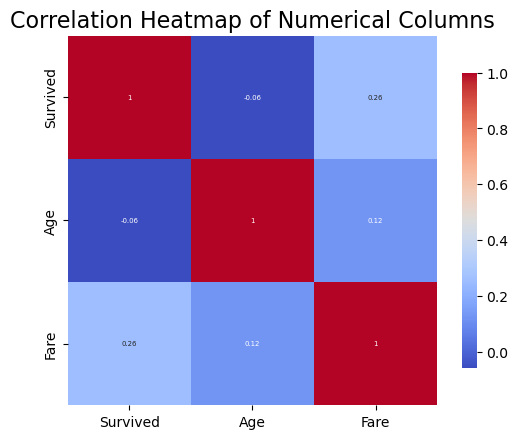

In [558]:
# Let's isolate our numerical columns first
num_cols = train_set[['Survived','Age','Fare']]

# Creating correlation matrix table
corr_index = num_cols.corr()

# Plotting the graph
sns.heatmap(
    corr_index,
    annot=True,
    cmap='coolwarm',
    annot_kws={"size": 5},
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0,
    linecolor=None
)

plt.title('Correlation Heatmap of Numerical Columns', fontsize=16)

Surprisingly, both 'Fare' and 'Age' aren't strongly correlated with 'Survived'. But since they also do not have any strong correlations with each other, I will not drop either of them. It is better to keep signals in the model than to continuously drop information.

### Categorical Feature Analysis

In [561]:
train_set.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,HasCabin,PartyBinned,Title
0,0,3,male,22.0,7.25,S,0,Couple,Mr.
1,1,1,female,38.0,71.28,C,1,Couple,Mrs.
2,1,3,female,26.0,7.92,S,0,Alone,Miss.
3,1,1,female,35.0,53.10,S,1,Couple,Mrs.
4,0,3,male,35.0,8.05,S,0,Alone,Mr.


Text(0.5, 1.0, 'Correlation Heatmap of Categorical Columns')

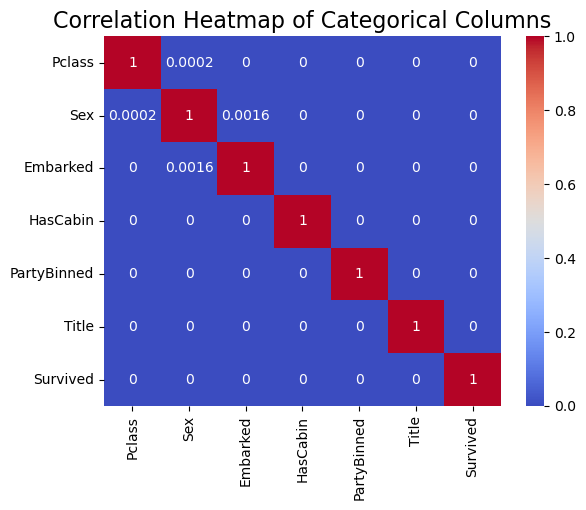

In [562]:
# Let's isolate our categorical columns first (I will include 'failed' as it is ultimately still a categorical variable)
cat_cols = ['Pclass','Sex','Embarked','HasCabin','PartyBinned','Title','Survived']

# Now let's create a square-shaped dataframe with cat_cols serving as both the rows and columns
p_value_matrix = pd.DataFrame(index=cat_cols,columns=cat_cols)

# Let's fill in each cell in the matrix with the p-values of the chi-squared test of independence between each pair of categorical columns
for col_a in cat_cols:
    for col_b in cat_cols:
        if col_a == col_b:
            p_value_matrix.loc[col_a,col_b] = 1
        else:
            contingency_table = pd.crosstab(train_set[col_a],train_set[col_b])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            p_value_matrix.loc[col_a,col_b] = round(p,4)

p_value_matrix = p_value_matrix.astype(float)

sns.heatmap(p_value_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Categorical Columns', fontsize=16)

For categorical variables, we're analysing the p-values of the chi-squared test of independence between X variables and between an X variable and 'Survived'. **The lower the value, the more of an association there is between variables.**

Because the p-values between categorical variables are so small, the correlation matrix above shows us that the categorical variables are all strongly associated. For this reason, no categorical variable should be dropped. 

## Part 6: Modelling on Train_Set

In [565]:
train_set.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,HasCabin,PartyBinned,Title
0,0,3,male,22.0,7.25,S,0,Couple,Mr.
1,1,1,female,38.0,71.28,C,1,Couple,Mrs.
2,1,3,female,26.0,7.92,S,0,Alone,Miss.
3,1,1,female,35.0,53.10,S,1,Couple,Mrs.
4,0,3,male,35.0,8.05,S,0,Alone,Mr.


### One-Hot Encoding Categorical Variables

In [567]:
# Converting Features to be Encoded to Str Dtype
train_set_cat = ['Pclass','Sex','Embarked','PartyBinned','Title']
train_set[train_set_cat].astype(str)

# Conducting one-hot encoding on categorical variables
encoder_train = OneHotEncoder(sparse_output=False, drop='first')
encoder_train_df = encoder_train.fit_transform(train_set[train_set_cat])
encoder_train_df = pd.DataFrame(encoder_train_df, columns=encoder_train.get_feature_names_out(train_set_cat))
encoder_train_df

,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,PartyBinned_Couple,PartyBinned_LargeFamily,PartyBinned_SmallMedFamily,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Title_Service
0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
888,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
889,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Combining Encoded Categorical Variables with Numerical Columns

In [569]:
# Defining numerical columns first
num_cols = ['Age','Fare']

# Concat encoded variables with num_cols
model_df = pd.concat([encoder_train_df, train_set['HasCabin'], train_set[num_cols]],axis=1)
model_df

,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,PartyBinned_Couple,PartyBinned_LargeFamily,PartyBinned_SmallMedFamily,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Title_Service,HasCabin,Age,Fare
0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,22.0,7.25
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,38.0,71.28
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,26.0,7.92
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,35.0,53.10
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,35.0,8.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,27.0,13.00
887,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,19.0,30.00
888,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,21.5,23.45
889,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,26.0,30.00


### Model Training & Predicting Using Train_Set

In [571]:
X_train_rf = model_df
y_train_actual_rf = train_set['Survived']

In [572]:
# n_estimators=100 refers to the number of trees built by the model
# random_state=42 is an arbitrary number that ensures the exact same model and results for every run
# class_weight='Balanced' is necessary as there are far less survived = 1 than survived = 0 
rf = RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=2, random_state=42, class_weight='balanced')
rf.fit(X_train_rf,y_train_actual_rf)

RandomForestClassifier(class_weight='balanced', max_depth=50, random_state=42)

In [573]:
y_train_predicted_rf = rf.predict(X_train_rf)

### Model Evaluation

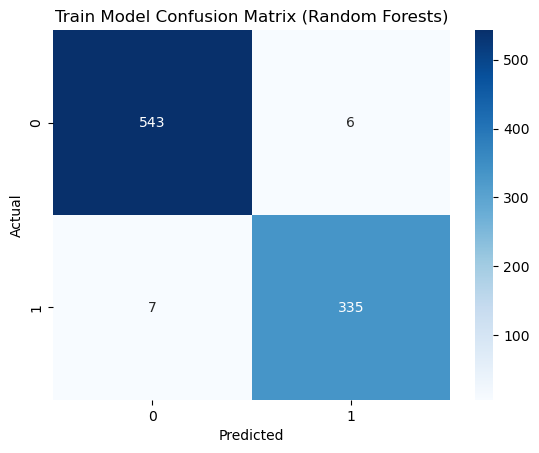

In [575]:
cm_train = confusion_matrix(y_train_actual_rf, y_train_predicted_rf)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Train Model Confusion Matrix (Random Forests)')
plt.show()

In [576]:
# What's the model's accuracy?
print(f'The model has an accuracy of {round(accuracy_score(y_train_actual_rf, y_train_predicted_rf)*100,2)}%.')

# What's the model's precision?
print(f'Among all predicted positives, {round(precision_score(y_train_actual_rf, y_train_predicted_rf)*100,2)}% were actual positives.')

# What's the model's recall?
print(f'Among all actual positives, the model correctly predicted {round(recall_score(y_train_actual_rf, y_train_predicted_rf),2)*100}%.')

# What's the model's specificity?
print(f'Among all actual negatives, the model correctly predicted {round(518/(518+31),2)*100}%.')

The model has an accuracy of 98.54%.
Among all predicted positives, 98.24% were actual positives.
Among all actual positives, the model correctly predicted 98.0%.
Among all actual negatives, the model correctly predicted 94.0%.


The model is extremely accurate at predicting whether a passenger survived in the train dataset. Overall, its accuracy is at 98.5%. Additionally, its precision, or its ability to make accurate predictions, is also high, at 98%.
Finally, its recall, or the model's ability to cover all actual 'y' values among its predictions, is also very high, at 94%.

At present, I feel confident about applying the same data cleaning, engineering and modelling processes I've used on the train dataset on the test dataset.

## Part 7: Preparing Test_Set for Modelling

### Loading & Cleaning Test_Set

For Train_Set, I did the following during the cleaning stage:

1. Impute null values under 'Embarked' and 'Age'
2. Create 'HasCabin' to differentiate between those who have and don't have 'Cabin'
3. Check for duplicates
4. Check for nonsensical values

In [581]:
test_set = pd.read_csv('/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/Personal Projects/Kaggle Titanic Competition/Datasets/test.csv')

In [582]:
round(test_set.isnull().sum()/len(test_set)*100,2)

PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            20.57
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.24
Cabin          78.23
Embarked        0.00
dtype: float64

Like train_set, > 70% of values under 'Cabin' in test_set are null.

While there are no null values under 'Embarked', 0.24% of values under 'Fare' are null. Hopefully I can simply impute the values based on publicly available information.

For 'Age', I will repeat my process for train_set, where I imputed the median according to 'Pclass' and 'Sex'.

#### Imputing null values under 'Fare'

In [585]:
test_set[test_set['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


According to [publicly available information](https://www.encyclopedia-titanica.org/titanic-victim/thomas-storey.html), Mr. Thomas Storey paid £7 5s (7 pounds and 5 shillings) for his ticket. 1 shilling = 0.05 pounds, so 5 shillings = 0.25 pounds, amounting to a total of 7.25 shillings paid.

I shall impute the null value with 7.25.

In [587]:
test_set.iloc[152, 8] = 7.25

#### Imputing null values under 'Age'

In [589]:
test_set['Age'] = test_set.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

#### Creating 'HasCabin'

In [591]:
def hascabin(x):
    if pd.isnull(x):
        return 0
    else:
        return 1

test_set['HasCabin'] = test_set['Cabin'].apply(hascabin)
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


#### Checking for Duplicates

In [593]:
test_set.duplicated(subset=['PassengerId']).sum()

0

#### Checking for Nonsensical Values

In [595]:
# Negative Values
num_negative_check = (test_set['PassengerId'] < 0)|(test_set['Pclass'] < 0)|(test_set['Age'] < 0)|(test_set['SibSp'] < 0)|(test_set['Parch'] < 0)|(test_set['Fare'] < 0)
test_set[num_negative_check]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin


In [596]:
# 'Sex' not 'Male' or 'Female'
sex_check = test_set[~test_set['Sex'].isin(['male','female'])]
sex_check

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin


In [597]:
# 'Pclass' not 1, 2 or 3
pclass_check = test_set[~test_set['Pclass'].isin([1,2,3])]
pclass_check

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin


In [598]:
# 'Embarked' not 'S', 'Q' or 'C'
embarked_check = test_set[~test_set['Embarked'].isin(['S','Q','C'])]
embarked_check

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin


### Feature Engineering on Test_Set

#### Combining 'SibSp' and 'Parch' to form 'PartySize', before creating 'PartyBinned'

In [601]:
# Remember to +1 to the number to represent the passenger themselves!
test_set['PartySize'] = test_set['SibSp'] + test_set['Parch'] + 1
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,PartySize
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,3


In [602]:
def partybin(x):
    if x == 1:
        return 'Alone'
    elif x == 2:
        return 'Couple'
    elif x > 2 and x < 6:
        return 'SmallMedFamily'
    elif x > 5:
        return 'LargeFamily'

test_set['PartyBinned'] = test_set['PartySize'].apply(partybin)

#### Extract Titles from 'Name'

In [604]:
test_set['Title'] = test_set['Name'].str.split(' ').str[1]
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,PartySize,PartyBinned,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,Alone,Mr.
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,2,Couple,Mrs.
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,Alone,Mr.
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,1,Alone,Mr.
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,3,SmallMedFamily,Mrs.


In [605]:
test_set['Title'].value_counts()

Title
Mr.             234
Miss.            77
Mrs.             70
Master.          19
y                 4
Col.              2
Rev.              2
Billiard,         2
Carlo,            1
Khalil,           1
Ms.               1
Palmquist,        1
Planke,           1
Messemaeker,      1
Dr.               1
Brito,            1
Name: count, dtype: int64

In [606]:
# Let's define all titles that are regular
reg_title = ['Mr.','Miss.','Mrs.','Master.']

# Let's isolate all names that don't have 'regular' titles
non_reg_title_rows = test_set[~test_set['Title'].isin(reg_title)]
non_reg_title_rows

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,PartySize,PartyBinned,Title
15,907,2,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,1,0,SC/PARIS 2167,27.7208,NaN,C,0,2,Couple,"Carlo,"
19,911,3,"Assaf Khalil, Mrs. Mariana (Miriam"")""",female,45.0,0,0,2696,7.2250,NaN,C,0,1,Alone,"Khalil,"
73,965,1,"Ovies y Rodriguez, Mr. Servando",male,28.5,0,0,PC 17562,27.7208,D43,C,1,1,Alone,y
88,980,3,"O'Donoghue, Ms. Bridget",female,22.0,0,0,364856,7.7500,NaN,Q,0,1,Alone,Ms.
103,995,3,"Johansson Palmquist, Mr. Oskar Leander",male,26.0,0,0,347070,7.7750,NaN,S,0,1,Alone,"Palmquist,"
131,1023,1,"Gracie, Col. Archibald IV",male,53.0,0,0,113780,28.5000,C51,C,1,1,Alone,Col.
145,1037,3,"Vander Planke, Mr. Julius",male,31.0,3,0,345763,18.0000,NaN,S,0,4,SmallMedFamily,"Planke,"
149,1041,2,"Lahtinen, Rev. William",male,30.0,1,1,250651,26.0000,NaN,S,0,3,SmallMedFamily,Rev.
164,1056,2,"Peruschitz, Rev. Joseph Maria",male,41.0,0,0,237393,13.0000,NaN,S,0,1,Alone,Rev.
192,1084,3,"van Billiard, Master. Walter John",male,11.5,1,1,A/5. 851,14.5000,NaN,S,0,3,SmallMedFamily,"Billiard,"


In [607]:
# Let's deal with them one by one, starting with 'y'
test_set[test_set['Title']=='y']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,PartySize,PartyBinned,Title
73,965,1,"Ovies y Rodriguez, Mr. Servando",male,28.5,0,0,PC 17562,27.7208,D43,C,1,1,Alone,y
220,1112,2,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,0,2,Couple,y
369,1261,2,"Pallas y Castello, Mr. Emilio",male,29.0,0,0,SC/PARIS 2147,13.8583,NaN,C,0,1,Alone,y
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1,1,Alone,y


Index #414's name has the title 'Dona.', which upon further research, I have found to be the feminine equivalent of 'Don.', a Spanish title for men of a higher social status. In the train set, the one person who had the title 'Don.' was categorised under 'Rare'. Because of this, I shall also re-title Index #414's title to 'Rare'. The other names shall just be re-titled to 'Mr' or 'Miss' where appropriate.

In [609]:
# Correcting 'y' titles to 'Mr.'
y_mr_index = [73,369]
test_set.iloc[y_mr_index,-1] = 'Mr.'

In [610]:
# Correcting 'y' title to 'Miss.'
test_set.iloc[220,-1] = 'Miss.'

In [611]:
# Correcting 'y' title to 'Rare'
test_set.iloc[414,-1] = 'Rare'

In [612]:
test_set['Title'].value_counts()

Title
Mr.             236
Miss.            78
Mrs.             70
Master.          19
Col.              2
Rev.              2
Billiard,         2
Carlo,            1
Khalil,           1
Ms.               1
Palmquist,        1
Planke,           1
Messemaeker,      1
Dr.               1
Brito,            1
Rare              1
Name: count, dtype: int64

In [613]:
# Let's now change the index with the title 'Ms.' to 'Miss.'
test_set[test_set['Title']=='Ms.']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,PartySize,PartyBinned,Title
88,980,3,"O'Donoghue, Ms. Bridget",female,22.0,0,0,364856,7.75,NaN,Q,0,1,Alone,Ms.


In [614]:
test_set.iloc[88,-1] = 'Miss.'

In [615]:
test_set['Title'].value_counts()

Title
Mr.             236
Miss.            79
Mrs.             70
Master.          19
Col.              2
Rev.              2
Billiard,         2
Carlo,            1
Khalil,           1
Palmquist,        1
Planke,           1
Messemaeker,      1
Dr.               1
Brito,            1
Rare              1
Name: count, dtype: int64

In [616]:
# There are many titles that are names, not actual titles. Let's single them out
reg_title = ['Mr.','Miss.','Mrs.','Master.','Col.','Rev.','Dr.','Rare']

# Let's isolate all names that don't have 'regular' titles
non_reg_title_rows = test_set[~test_set['Title'].isin(reg_title)]
non_reg_title_rows

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,PartySize,PartyBinned,Title
15,907,2,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,1,0,SC/PARIS 2167,27.7208,NaN,C,0,2,Couple,"Carlo,"
19,911,3,"Assaf Khalil, Mrs. Mariana (Miriam"")""",female,45.0,0,0,2696,7.2250,NaN,C,0,1,Alone,"Khalil,"
103,995,3,"Johansson Palmquist, Mr. Oskar Leander",male,26.0,0,0,347070,7.7750,NaN,S,0,1,Alone,"Palmquist,"
145,1037,3,"Vander Planke, Mr. Julius",male,31.0,3,0,345763,18.0000,NaN,S,0,4,SmallMedFamily,"Planke,"
192,1084,3,"van Billiard, Master. Walter John",male,11.5,1,1,A/5. 851,14.5000,NaN,S,0,3,SmallMedFamily,"Billiard,"
260,1152,3,"de Messemaeker, Mr. Guillaume Joseph",male,36.5,1,0,345572,17.4000,NaN,S,0,2,Couple,"Messemaeker,"
336,1228,2,"de Brito, Mr. Jose Joaquim",male,32.0,0,0,244360,13.0000,NaN,S,0,1,Alone,"Brito,"
344,1236,3,"van Billiard, Master. James William",male,24.0,1,1,A/5. 851,14.5000,NaN,S,0,3,SmallMedFamily,"Billiard,"


In [617]:
# Let's first address all indexes where 'Title' is supposed to be 'Mrs.'
name_mrs_index = [15,19]
test_set.iloc[name_mrs_index,-1] = 'Mrs.'

In [618]:
# Now let's address all indexes where 'Title' is supposed to be 'Mr.'
name_mr_index = [103,145,260,336]
test_set.iloc[name_mr_index,-1] = 'Mr.'

In [619]:
# Now let's address all indexes where 'Title' is supposed to be 'Master.'
name_master_index = [192,344]
test_set.iloc[name_master_index,-1] = 'Master.'

In [620]:
test_set['Title'].value_counts()

Title
Mr.        240
Miss.       79
Mrs.        72
Master.     21
Col.         2
Rev.         2
Dr.          1
Rare         1
Name: count, dtype: int64

In [621]:
# Let's combine 'Rev.' and 'Dr.' under the same category, 'Service'
svc_titles = ['Rev.','Dr.']
test_set.iloc[test_set[test_set['Title'].isin(svc_titles)].index,-1] = 'Service'

In [622]:
# Let's combine all military titles and noble titles under 'Rare'
rare_titles = ['Col.','Rare']
test_set.iloc[test_set[test_set['Title'].isin(rare_titles)].index,-1] = 'Rare'

In [623]:
# Let's correct all the 'Master.' titles to omit the period
test_set.iloc[test_set[test_set['Title']=='Master.'].index,-1] = 'Master'

In [624]:
test_set['Title'].value_counts()

Title
Mr.        240
Miss.       79
Mrs.        72
Master      21
Rare         3
Service      3
Name: count, dtype: int64

#### Dropping Irrelevant Columns

Now, we need to drop the following columns:

1. 'PassengerId'
2. 'Name'
3. 'SibSp'
4. 'Parch'
5. 'Ticket'
6. 'Cabin'
7. 'PartySize'

In [627]:
to_drop = ['PassengerId','Name','SibSp','Parch','Ticket','Cabin','PartySize']
test_set = test_set.drop(to_drop,axis=1)
test_set.head()

,Pclass,Sex,Age,Fare,Embarked,HasCabin,PartyBinned,Title
0,3,male,34.5,7.8292,Q,0,Alone,Mr.
1,3,female,47.0,7.0000,S,0,Couple,Mrs.
2,2,male,62.0,9.6875,Q,0,Alone,Mr.
3,3,male,27.0,8.6625,S,0,Alone,Mr.
4,3,female,22.0,12.2875,S,0,SmallMedFamily,Mrs.


In [628]:
# Finally, let's round the values under 'Fare' to 2 D.P.
test_set['Fare'] = test_set['Fare'].round(2)
test_set.head()

,Pclass,Sex,Age,Fare,Embarked,HasCabin,PartyBinned,Title
0,3,male,34.5,7.83,Q,0,Alone,Mr.
1,3,female,47.0,7.00,S,0,Couple,Mrs.
2,2,male,62.0,9.69,Q,0,Alone,Mr.
3,3,male,27.0,8.66,S,0,Alone,Mr.
4,3,female,22.0,12.29,S,0,SmallMedFamily,Mrs.


In [629]:
test_set['PartyBinned'].value_counts()

PartyBinned
Alone             253
SmallMedFamily     78
Couple             74
LargeFamily        13
Name: count, dtype: int64

### Preparing Test_Set for Modelling

In [631]:
# Converting Features to be Encoded to Str Dtype
test_set_cat = ['Pclass','Sex','Embarked','PartyBinned','Title']
test_set[test_set_cat].astype(str)

# Conducting one-hot encoding on categorical variables
encoder_test = OneHotEncoder(sparse_output=False, drop='first')
encoder_test_df = encoder_test.fit_transform(test_set[test_set_cat])
encoder_test_df = pd.DataFrame(encoder_test_df, columns=encoder_test.get_feature_names_out(test_set_cat))
encoder_test_df

,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,PartyBinned_Couple,PartyBinned_LargeFamily,PartyBinned_SmallMedFamily,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Title_Service
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
415,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
416,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [632]:
test_set.head()

,Pclass,Sex,Age,Fare,Embarked,HasCabin,PartyBinned,Title
0,3,male,34.5,7.83,Q,0,Alone,Mr.
1,3,female,47.0,7.00,S,0,Couple,Mrs.
2,2,male,62.0,9.69,Q,0,Alone,Mr.
3,3,male,27.0,8.66,S,0,Alone,Mr.
4,3,female,22.0,12.29,S,0,SmallMedFamily,Mrs.


In [633]:
# Defining numerical columns first
num_cols = ['Age','Fare']

# Concat encoded variables with num_cols
model_df_test = pd.concat([encoder_test_df, test_set['HasCabin'], test_set[num_cols]],axis=1)
model_df_test.head()

,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,PartyBinned_Couple,PartyBinned_LargeFamily,PartyBinned_SmallMedFamily,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Title_Service,HasCabin,Age,Fare
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,34.5,7.83
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,47.0,7.00
2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,62.0,9.69
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,27.0,8.66
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,22.0,12.29


### Predicting 'Survived' Using the Random Forest Model

In [635]:
X_test_rf = model_df_test
y_test_predicted_rf = rf.predict(X_test_rf)

In [636]:
y_test_prediction_df_V3 = pd.DataFrame(y_test_predicted_rf)
y_test_prediction_df_V3

,0
0,0
1,0
2,0
3,1
4,1
...,...
413,0
414,1
415,0
416,0


In [637]:
og_test = pd.read_csv('/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/Personal Projects/Kaggle Titanic Competition/Datasets/test.csv')
og_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [638]:
y_test_prediction_df = pd.concat([og_test['PassengerId'],y_test_prediction_df_V3],axis=1)
y_test_prediction_df

,PassengerId,0
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [639]:
# Let's rename the '0' column to 'Survived'
y_test_prediction_df = y_test_prediction_df.rename(columns={0:'Survived'})

In [640]:
# Finally, let's save the dataframe as a csv
y_test_prediction_df.to_csv('y_test_prediction_df.csv',index=False)

### Part 8: Conclusion

Overall, my model performed decently, attaining an accuracy score on Kaggle of ~0.744.